### 실습 목차
* 1. Seq2seq with Attention 구현
  * 1-1. 학습 전처리 코드 구현
  * 1-2. Encoder 구현
  * 1-3. Decoder 구현
* 2. Seq2seq 번역 학습
* 3. 학습된 Seq2seq 번역 시각화

In [1]:
# # 번역 데이터셋 다운로드
# !echo "download machine translation dataset from http://www.manythings.org/anki/..."

# !curl -o "fra-eng.zip" "http://www.manythings.org/anki/fra-eng.zip"

# !unzip './fra-eng.zip'

In [2]:
# !mkdir "/home/pervinco/Datasets/fra-eng"
# !mv "fra-eng.zip" "/home/pervinco/Datasets/fra-eng/"
# !mv "fra.txt" "/home/pervinco/Datasets/fra-eng/"
# !mv "_about.txt" "/home/pervinco/Datasets/fra-eng/"

In [6]:
with open("/home/pervinco/Datasets/fra-eng/fra.txt") as f:
    lines = f.readlines() 


print(len(lines))
print(lines[0])

232736
Go.	Va !	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)



In [3]:
# 라이브러리 import
import os
import re
import nltk
import torch
import random
import unicodedata
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from torch import nn
from torch import optim
from copy import deepcopy
from torch.autograd import Variable
from torch.nn import functional as F
from collections import Counter, OrderedDict
from torch.nn.utils.rnn import PackedSequence, pack_padded_sequence

flatten = lambda l: [item for sublist in l for item in sublist]

random.seed(7)
%matplotlib inline
from warnings import filterwarnings
filterwarnings('ignore')

In [4]:
# GPU 설정
USE_CUDA = torch.cuda.is_available() # 현재 환경에서 CUDA를 사용할 수 있는지 확인

# CUDA를 사용할 수 있으면 CUDA tensor를, 그렇지 않으면 CPU tensor를 사용
FloatTensor = torch.cuda.FloatTensor if USE_CUDA else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if USE_CUDA else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if USE_CUDA else torch.ByteTensor

#### 데이터셋 전처리 코드 구현

##### getBatch 함수 구현

`getBatch` 함수는 주어진 `train_data`에서 무작위로 선택된 배치 (batch)를 생성하는 역할을 합니다. 이 함수는 다음과 같은 과정을 거쳐 배치를 생성합니다:

- `train_data`를 무작위로 섞습니다
- `sindex`와 `eindex` 변수를 사용하여 `train_data`에서 배치를 추출합니다. `sindex`는 시작 인덱스를 나타내고, `eindex`는 끝 인덱스를 나타냅니다
- `eindex`를 `batch_size`만큼 증가시키고, `sindex`를 이전 `eindex` 값으로 업데이트합니다
- `eindex`가 `train_data`의 길이보다 작은 동안 위 과정을 반복하며 배치를 생성합니다
- `eindex`가 `train_data`의 길이보다 크거나 같아지면, 남은 데이터를 마지막 배치로 생성합니다

In [5]:
# 배치 데이터를 가져오는 함수
def getBatch(batch_size, train_data):
    random.shuffle(train_data) # 데이터를 무작위로 섞음
    sindex = 0 # 시작 인덱스
    eindex = batch_size # 끝 인덱스
    while eindex < len(train_data): # 끝 인덱스가 데이터의 길이보다 작을 동안
        batch = train_data[sindex: eindex] # 배치 데이터를 가져옴
        temp = eindex
        eindex = eindex + batch_size # 끝 인덱스를 배치 크기만큼 증가
        sindex = temp # 시작 인덱스를 이전 끝 인덱스로 업데이트
        yield batch # 배치 데이터 반환

    if eindex >= len(train_data): # 끝 인덱스가 데이터의 길이보다 크거나 같으면
        batch = train_data[sindex:] # 남은 데이터를 배치로 만듦
        yield batch # 배치 데이터 반환

##### pad_to_batch 함수 구현

이 함수는 주어진 배치에 패딩을 적용하여 입력 시퀀스와 타겟 시퀀스를 동일한 길이로 만듭니다. 이를 통해 배치 처리를 수행할 수 있습니다

함수는 다음 단계를 수행합니다:

1. 배치를 길이에 따라 정렬
2. 입력 시퀀스와 타겟 시퀀스의 최대 길이를 계산
3. 각 시퀀스에 패딩을 적용하여 동일한 길이로 변환
4. 입력 변수와 타겟 변수를 생성하고, 각 시퀀스의 실제 길이를 계산
5. 입력 변수, 타겟 변수, 입력 길이, 타겟 길이를 반환

이 함수를 사용하면, 입력 시퀀스와 타겟 시퀀스를 동일한 길이로 만들어 배치 처리를 수행할 수 있습니다

In [6]:
# 시퀀스를 배치로 변환하는 함수
def pad_to_batch(batch, x_to_ix, y_to_ix):
    sorted_batch =  sorted(batch, key=lambda b:b[0].size(1), reverse=True) # 길이에 따라 배치를 정렬
    x,y = list(zip(*sorted_batch)) # 입력과 출력을 분리
    max_x = max([s.size(1) for s in x]) # 입력의 최대 길이
    max_y = max([s.size(1) for s in y]) # 출력의 최대 길이
    x_p, y_p = [], [] # 패딩을 적용할 입력과 출력 리스트

    for i in range(len(batch)):
        if x[i].size(1) < max_x: # 입력의 길이가 최대 길이보다 작으면
            # 패딩 토큰을 추가하여 최대 길이에 맞춤
            x_p.append(torch.cat([x[i], Variable(LongTensor([x_to_ix['<PAD>']] * (max_x - x[i].size(1)))).view(1, -1)], 1))
        else:
            x_p.append(x[i]) # 그렇지 않으면 그대로 사용
        if y[i].size(1) < max_y: # 출력의 길이가 최대 길이보다 작으면
            # 패딩 토큰을 추가하여 최대 길이에 맞춤
            y_p.append(torch.cat([y[i], Variable(LongTensor([y_to_ix['<PAD>']] * (max_y - y[i].size(1)))).view(1, -1)], 1))
        else:
            y_p.append(y[i]) # 그렇지 않으면 그대로 사용

    input_var = torch.cat(x_p) # 입력 변수
    target_var = torch.cat(y_p) # 목표 변수
    input_len = [list(map(lambda s: s ==0, t.data)).count(False) for t in input_var] # 입력의 실제 길이
    target_len = [list(map(lambda s: s ==0, t.data)).count(False) for t in target_var] # 출력의 실제 길이

    return input_var, target_var, input_len, target_len

##### 데이터셋 load 및 preprocess 코드 구현

이 코드에서는 문자열을 처리하고 정규화하는 두 가지 함수를 구현합니다.

1. `unicode_to_ascii` 함수는 유니코드 문자열을 ASCII 문자열로 변환합니다. 이 함수는 주어진 유니코드 문자열에서 각 문자를 순회하며, 해당 문자가 비수치형(non-mark)인 경우에만 ASCII 문자열에 추가합니다. 이를 통해 유니코드 문자열이 ASCII 문자열로 변환됩니다

<br>

2. `normalize_string` 함수는 문자열을 소문자로 변환하고, 공백을 제거하며, 영문자와 구두점 이외의 문자를 제거합니다. 이 함수는 다음과 같은 순서로 작동합니다:
* 문자열을 소문자로 변환하고 양쪽 공백을 제거
* 구두점 앞뒤에 공백을 추가하여 구두점과 단어가 구분되도록 함
* 영문자, 구두점 이외의 문자를 제거
* 연속된 공백을 하나의 공백으로 치환하고, 문자열의 앞뒤 공백을 제거

이 두 함수를 사용하여 문자열을 처리하고 정규화할 수 있습니다. 정규화된 데이터는 모델의 입력 데이터를 적절한 형태로 사용됩니다

In [7]:
# 유니코드 문자열을 아스키 문자열로 변환하는 함수
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# 문자열을 정규화하는 함수
def normalize_string(s):
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r"([,.!?])", r" \1 ", s)
    s = re.sub(r"[^a-zA-Z,.!?]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s

##### 데이터 전처리 및 필터링

이 코드에서는 기계 번역을 위한 데이터 전처리와 필터링을 수행합니다

먼저, 최소 및 최대 길이를 설정합니다. 이를 통해 너무 짧거나 너무 긴 문장을 제외할 수 있습니다

- `MIN_LENGTH` : 문장의 최소 길이를 지정합니다. 여기서는 3으로 설정했습니다
- `MAX_LENGTH` : 문장의 최대 길이를 지정합니다. 여기서는 25로 설정했습니다

그런 다음 빈 리스트 `X_r`와 `y_r`을 생성합니다. 이 리스트들은 각각 원문(source)과 번역문(target)의 문장을 저장할 것입니다

`corpus`의 각 문장에 대해 다음 작업을 수행합니다:

1. 원문(source)과 번역문(target)을 분리합니다. 이 경우에는 탭(\t)으로 구분되어 있습니다
2. 원문과 번역문이 비어 있지 않은지 확인합니다. 비어 있다면 해당 문장을 건너뜁니다
3. 원문과 번역문을 정규화(normalize)하고 공백으로 분리합니다
4. 원문과 번역문의 길이가 설정한 최소 및 최대 길이 사이에 있는지 확인합니다 만약 그렇다면, `X_r`과 `y_r`에 각각 원문과 번역문을 추가합니다

In [8]:
# 프랑스어-영어 병렬 코퍼스를 읽어옴
corpus = open('/home/pervinco/Datasets/fra-eng/fra.txt', 'r', encoding='utf-8').readlines()

corpus = corpus[:30000] # 3만개의 데이터만 사용

print(len(corpus))
print(corpus[0])

30000
Go.	Va !	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)



In [9]:
MIN_LENGTH = 3
MAX_LENGTH = 25

X_r, y_r = [], [] # 원시 데이터를 저장할 빈 리스트 생성

# 데이터 전처리
for parallel in corpus:
    so,ta,_ = parallel[:-1].split('\t') # 입력 문장과 출력 문장을 분리
    if so.strip() == "" or ta.strip() == "": # 만약 입력 문장이나 출력 문장이 비어있으면 무시
        continue

    normalized_so = normalize_string(so).split() # 입력 문장을 정규화하고 단어 단위로 분리
    normalized_ta = normalize_string(ta).split() # 출력 문장을 정규화하고 단어 단위로 분리

    # 입력 문장과 출력 문장의 길이가 최소 길이와 최대 길이 사이에 있으면 리스트에 추가
    if len(normalized_so) >= MIN_LENGTH and len(normalized_so) <= MAX_LENGTH \
    and len(normalized_ta) >= MIN_LENGTH and len(normalized_ta) <= MAX_LENGTH:
        X_r.append(normalized_so)
        y_r.append(normalized_ta)

print(len(X_r), len(y_r)) # 입력 문장과 출력 문장의 개수 출력
print(X_r[0], y_r[0]) # 첫 번째 입력 문장과 출력 문장 출력

29444 29444
['i', 'see', '.'] ['je', 'comprends', '.']


##### 소스 및 타겟 단어장 (Vocabulary) 생성
소스와 타겟 데이터를 사용하여 각각의 단어 기반의 단어장 (Vocabulary)을 생성합니다. 이를 위해 먼저 소스와 타겟 데이터를 flatten한 후, 중복된 단어를 제거하기 위해 `set()` 함수를 사용합니다. 이렇게 생성된 단어장은 각각 `source_vocab`과 `target_vocab`에 저장됩니다

`len(source_vocab)`와 `len(target_vocab)`를 출력하여 각각의 단어장에 포함된 단어의 개수를 확인할 수 있습니다

##### 인덱스 매핑 생성
단어장을 기반으로 단어와 인덱스 사이의 매핑을 생성합니다. 이를 위해 먼저 `<PAD>`, `<UNK>`, `<s>`, `</s>`와 같은 특수 토큰을 포함한 초기 매핑 딕셔너리를 생성합니다. 각각의 특수 토큰은 다음과 같은 역할을 합니다:
- `<PAD>` : 패딩(Padding) 토큰으로, 배치 처리를 위해 서로 다른 길이의 시퀀스를 동일한 길이로 맞추기 위해 사용
- `<UNK>` : 알 수 없는(Unknown) 토큰으로, 단어장에 없는 단어를 대체하는 데 사용
- `<s>` : 시작(Start) 토큰으로, 디코더의 입력 시퀀스의 시작을 나타냄
- `</s>` : 종료(End) 토큰으로, 디코더의 출력 시퀀스의 종료를 나타냄

`source2index`와 `target2index` 딕셔너리에 각각 소스와 타겟 단어장의 단어들을 추가합니다. 이 때, 이미 딕셔너리에 존재하는 단어는 추가하지 않습니다.

마지막으로, `index2source`와 `index2target` 딕셔너리를 생성하여 인덱스와 단어 사이의 역매핑을 구성합니다. 이렇게 생성된 매핑 딕셔너리들은 추후에 데이터 전처리 및 결과 해석에 사용됩니다

In [10]:
# 소스와 타겟 어휘집을 생성
source_vocab = list(set(flatten(X_r))) # 소스 어휘집 생성
target_vocab = list(set(flatten(y_r))) # 타겟 어휘집 생성
print(len(source_vocab), len(target_vocab)) # 소스 어휘집과 타겟 어휘집의 크기 출력

# 소스와 타겟 어휘집을 인덱스로 변환하는 딕셔너리 생성
source2index = {'<PAD>': 0, '<UNK>': 1, '<s>': 2, '</s>': 3} # 소스 어휘집을 인덱스로 변환하는 딕셔너리 초기화
for vo in source_vocab: # 소스 어휘집의 각 단어에 대해
    if source2index.get(vo) is None: # 해당 단어가 딕셔너리에 없다면
        source2index[vo] = len(source2index) # 딕셔너리에 추가
index2source = {v:k for k, v in source2index.items()} # 인덱스를 소스 어휘집으로 변환하는 딕셔너리 생성

target2index = {'<PAD>': 0, '<UNK>': 1, '<s>': 2, '</s>': 3} # 타겟 어휘집을 인덱스로 변환하는 딕셔너리 초기화
for vo in target_vocab: # 타겟 어휘집의 각 단어에 대해
    if target2index.get(vo) is None: # 해당 단어가 딕셔너리에 없다면
        target2index[vo] = len(target2index) # 딕셔너리에 추가
index2target = {v:k for k, v in target2index.items()} # 인덱스를 타겟 어휘집으로 변환하는 딕셔너리 생성

4269 7409


##### prepare_sequence 함수와 데이터 전처리

- `prepare_sequence` 함수는 주어진 시퀀스를 인덱스로 변환하는 함수입니다. 이 함수는 seq(단어 시퀀스)와 to_index(단어를 인덱스로 매핑하는 딕셔너리)를 입력으로 받아, 시퀀스의 각 단어를 해당 인덱스로 변환하고, 이를 PyTorch의 Variable로 변환하여 반환합니다. 만약 단어가 to_index 딕셔너리에 없으면, "<UNK>"(unknown) 토큰의 인덱스로 변환합니다

- 이후, 전처리된 원문(X_r)과 번역문(y_r) 데이터를 사용하여, 각 시퀀스의 끝에 "</s>"(end of sentence) 토큰을 추가하고, prepare_sequence 함수를 사용하여 인덱스로 변환한 후, 이를 PyTorch의 Variable로 변환합니다. 이렇게 변환된 데이터를 X_p와 y_p 리스트에 저장합니다

- 마지막으로, 변환된 원문(X_p)과 번역문(y_p) 데이터를 zip 함수를 사용하여 쌍으로 묶어 train_data 리스트에 저장합니다. 이렇게 생성된 train_data는 원문과 번역문의 쌍으로 이루어진 학습 데이터입니다

In [11]:
# 시퀀스를 준비하는 함수
def prepare_sequence(seq, to_index):
    idxs = list(map(lambda w: to_index[w] if to_index.get(w) is not None else to_index["<UNK>"], seq)) # 시퀀스를 인덱스로 변환
    return Variable(LongTensor(idxs)) # 변환된 인덱스를 텐서로 변환

X_p, y_p = [], []

for so, ta in zip(X_r, y_r): # 각 소스와 타겟에 대해
    X_p.append(prepare_sequence(so + ['</s>'], source2index).view(1, -1)) # 소스 시퀀스를 인덱스로 변환하여 리스트에 추가
    y_p.append(prepare_sequence(ta + ['</s>'], target2index).view(1, -1)) # 타겟 시퀀스를 인덱스로 변환하여 리스트에 추가

train_data = list(zip(X_p, y_p)) # 소스와 타겟 시퀀스를 튜플로 묶어 학습 데이터 생성

train_data[:5] # 학습 데이터의 첫 5개를 출력


[(tensor([[2633, 2184, 2358,    3]], device='cuda:0'),
  tensor([[1409, 2076, 4722,    3]], device='cuda:0')),
 (tensor([[2633,   32, 2358,    3]], device='cuda:0'),
  tensor([[2320, 5337, 4722,    3]], device='cuda:0')),
 (tensor([[2633, 2497,  137,    3]], device='cuda:0'),
  tensor([[2320, 1550, 6190, 1942,    3]], device='cuda:0')),
 (tensor([[2633, 2497,  137,    3]], device='cuda:0'),
  tensor([[1409, 1726, 1550,  833, 1942,    3]], device='cuda:0')),
 (tensor([[2633, 2497, 2358,    3]], device='cuda:0'),
  tensor([[2320, 1550, 6190, 4722,    3]], device='cuda:0'))]

#### Encoder 구현

##### pack_padded_sequence와 pad_packed_sequence

`torch.nn.utils.rnn.pack_padded_sequence`와 `torch.nn.utils.rnn.pad_packed_sequence`는 PyTorch에서 제공하는 유틸리티 함수로, 패딩된 시퀀스를 처리할 때 사용됩니다

- `pack_padded_sequence` : 패딩된 시퀀스를 입력으로 받아, 패딩되지 않은 시퀀스로 변환합니다. 이 함수는 RNN 계열 모델에 입력하기 전에 사용되며, RNN 계열 모델이 패딩된 부분을 처리하지 않도록 도와줍니다. 이 함수는 입력 시퀀스와 각 시퀀스의 실제 길이를 인자로 받습니다

- `pad_packed_sequence` : 패딩되지 않은 시퀀스를 입력으로 받아, 패딩된 시퀀스로 변환합니다. 이 함수는 RNN 계열 모델의 출력을 처리할 때 사용되며, 패딩된 시퀀스 형태로 복원해줍니다.


##### nn.Embedding

`nn.Embedding`은 PyTorch에서 제공하는 임베딩 레이어로, 정수 인코딩된 단어를 벡터 형태로 변환하는 역할을 합니다. 이 레이어는 단어 임베딩을 학습하고 저장하는 기능을 수행합니다

`nn.Embedding`의 초기화(`__init__`) 인자는 다음과 같습니다:

- `num_embeddings` : 임베딩 레이어에 저장할 단어의 개수를 지정합니다. 이는 단어장의 크기와 동일해야 합니다

- `embedding_dim` : 임베딩 벡터의 차원을 지정합니다. 이는 각 단어의 임베딩 벡터의 크기를 의미합니다

임베딩 레이어는 정수 인코딩된 단어를 입력으로 받아 해당 단어의 임베딩 벡터를 반환합니다

##### Encoder 구현

Encoder 클래스는 Seq2Seq 모델의 인코더 부분을 구현한 클래스입니다. 인코더는 입력 시퀀스를 받아서 고정된 크기의 은닉 상태 벡터로 변환하는 역할을 합니다. 이 클래스는 GRU를 사용하여 구해봅시다

`Encoder` 클래스의 초기화 인자는 다음과 같습니다:

- `input_size` : 인코더의 입력 차원의 크기를 지정합니다. 이는 입력 단어의 원-핫 벡터 크기와 동일합니다

- `embedding_size` : 임베딩 레이어의 출력 차원의 크기를 지정합니다. 이는 각 단어의 임베딩 벡터의 크기를 의미합니다

- `hidden_size` : GRU 모듈의 은닉 상태의 크기를 지정합니다. 이는 GRU의 은닉층의 뉴런 수를 의미합니다

- `n_layers` : GRU 셀을 몇 층으로 쌓을 것인지를 결정합니다. 기본값은 1입니다

- `bidirec` : 양방향 GRU를 사용할지 여부를 결정하는 옵션입니다. 기본값은 False입니다. True로 설정하면 양방향 GRU가 사용됩니다

<br>

`forward` 메서드는 인코더의 순전파를 구현한 메서드입니다. 이 메서드는 다음과 같은 인자를 받습니다:

- `inputs` : 입력 시퀀스의 배치를 나타내는 텐서입니다. 형태는 (배치 크기, 시퀀스 길이)입니다

- `input_lengths` : 입력 시퀀스의 실제 길이를 나타내는 리스트입니다. 이는 패딩된 시퀀스를 처리하기 위해 사용됩니다

`forward` 메서드는 입력 시퀀스를 임베딩 레이어를 통과시키고, 패딩된 시퀀스를 처리하기 위해 패킹 및 언패킹을 수행합니다. 그 후, GRU를 통과시켜 출력과 은닉 상태를 얻습니다. 마지막으로 은닉 상태를 반환합니다

In [12]:
# 인코더 클래스 정의
class Encoder(nn.Module):
    # 초기화 함수
    def __init__(self, input_size, embedding_size,hidden_size, n_layers=1,bidirec=False):
        super(Encoder, self).__init__()

        # 인코더의 입력 크기, 은닉층 크기, 레이어 수 설정
        # input_size: 입력 데이터의 차원 수
        # hidden_size: 은닉층의 노드 수
        # n_layers: 은닉층의 수
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        # 임베딩 레이어를 정의
        # 임베딩 레이어는 입력 데이터를 임베딩 벡터로 변환하는 역할을 함
        self.embedding = nn.Embedding(input_size, embedding_size)

        # 양방향 GRU를 사용할지 여부에 따라 GRU 레이어
        # 양방향 GRU를 사용하면, n_direction을 2로 설정하고, 그렇지 않으면 1로 설정
        if bidirec:
            self.n_direction = 2
            self.gru = nn.GRU(embedding_size, hidden_size, n_layers, batch_first=True, bidirectional=True)
        else:
            self.n_direction = 1
            self.gru = nn.GRU(embedding_size, hidden_size, n_layers, batch_first=True)

    # 은닉 상태를 초기화하는 함수
    # 입력의 크기에 따라 0으로 채워진 텐서를 생성하고, CUDA를 사용할 경우 GPU로 이동
    def init_hidden(self, inputs):
        hidden = Variable(torch.zeros(self.n_layers * self.n_direction, inputs.size(0), self.hidden_size))
        return hidden.cuda() if USE_CUDA else hidden

    # 가중치를 초기화하는 함수
    # 임베딩 레이어와 GRU 레이어의 가중치를 xavier_uniform 방식으로 초기화
    def init_weight(self):
        self.embedding.weight = nn.init.xavier_uniform(self.embedding.weight)
        self.gru.weight_hh_l0 = nn.init.xavier_uniform(self.gru.weight_hh_l0)
        self.gru.weight_ih_l0 = nn.init.xavier_uniform(self.gru.weight_ih_l0)

    # 순전파 정의
    # 입력과 입력 길이를 받아서 임베딩 레이어와 GRU 레이어를 통과
    # GRU 레이어의 출력과 은닉 상태를 반환
    def forward(self, inputs, input_lengths):
        hidden = self.init_hidden(inputs)

        embedded = self.embedding(inputs)
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths, batch_first=True)
        outputs, hidden = self.gru(packed, hidden)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs, batch_first=True)

        # 레이어 수가 1보다 크면, 마지막 두 레이어의 은닉 상태를 사용하고, 그렇지 않으면 마지막 레이어의 은닉 상태를 사용
        if self.n_layers > 1:
            if self.n_direction == 2:
                hidden = hidden[-2:]
            else:
                hidden = hidden[-1]

        return outputs, torch.cat([h for h in hidden], 1).unsqueeze(1)


#### Decoder 구현


Decoder는 Seq2Seq 모델의 출력 시퀀스를 생성하는 부분입니다. 주어진 인코더의 출력과 이전 시점의 출력을 기반으로 다음 시점의 출력을 생성합니다. 이 과정에서 어텐션 메커니즘을 사용하여 입력 시퀀스와 출력 시퀀스 사이의 연관성을 학습합니다

아래에서 구현 할 Decoder 클래스는 다음과 같은 구성 요소를 가집니다:

- `__init__` : 초기화 함수로, 입력 크기, 임베딩 크기, 은닉 크기, 층의 개수, 드롭아웃 확률 등을 인자로 받습니다
- `init_hidden` : 초기 은닉 상태를 생성하는 함수로, 입력 텐서를 인자로 받아 은닉 상태를 초기화합니다
- `init_weight` : 가중치를 초기화하는 함수로, Xavier 초기화 방법을 사용하여 임베딩, GRU, 선형, 어텐션 계층의 가중치를 초기화합니다
- `Attention` : 어텐션 메커니즘을 구현하는 함수로, 현재 은닉 상태, 인코더 출력, 인코더 마스킹을 인자로 받아 컨텍스트 벡터와 어텐션 가중치를 반환합니다
- `forward` : 디코더의 순전파를 구현하는 함수로, 입력 텐서, 컨텍스트 벡터, 최대 길이, 인코더 출력, 인코더 마스킹, 학습 여부를 인자로 받아 예측된 출력을 반환합니다
- `decode` : 주어진 컨텍스트 벡터와 인코더 출력을 사용하여 출력 시퀀스를 생성하는 함수입니다. 이 함수는 디코더의 순전파를 반복적으로 수행하여 출력 시퀀스를 생성하고, 어텐션 가중치를 반환합니다

<br>

`Attention` 함수는 주어진 현재 은닉 상태와 인코더 출력을 사용하여 어텐션 메커니즘을 구현합니다. 어텐션 메커니즘은 입력 시퀀스와 출력 시퀀스 사이의 연관성을 학습하여, 각 시점에서 어떤 입력 단어에 집중해야 하는지를 결정합니다

우리는 Bahdanau Attention을 사용하여 Attention function을 구현하겠습니다

어텐션 메커니즘의 수식은 다음과 같습니다:

1. 에너지 계산: $e_{ij} = a(s_{i-1}, h_j)$
   - $s_{i-1}$: 이전 시점의 디코더 은닉 상태
   - $h_j$: 인코더 출력의 j번째 단어에 대한 은닉 상태
   - $a$: 어텐션 함수 (여기서는 선형 계층 `self.attn`을 사용)

2. 어텐션 가중치 계산: $\alpha_{ij} = \frac{\exp(e_{ij})}{\sum_{k=1}^T \exp(e_{ik})}$
   - $\alpha_{ij}$: i번째 디코더 출력과 j번째 인코더 입력 사이의 어텐션 가중치

3. 컨텍스트 벡터 계산: $c_i = \sum_{j=1}^T \alpha_{ij} h_j$
   - $c_i$: i번째 디코더 출력에 대한 컨텍스트 벡터

In [13]:
class Decoder(nn.Module):
    # 초기화 함수
    def __init__(self, input_size, embedding_size, hidden_size, n_layers=1, dropout_p=0.1):
        super(Decoder, self).__init__()

        # 디코더의 은닉층 크기와 레이어 수를 설정
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        # 임베딩 레이어를 생성. 입력 크기와 임베딩 크기를 인자로 받음
        self.embedding = nn.Embedding(input_size, embedding_size)
        # 드롭아웃 레이어를 생성. 드롭아웃 확률을 인자로 받음
        self.dropout = nn.Dropout(dropout_p)
        # GRU 레이어를 생성. 임베딩 크기 + 은닉층 크기, 은닉층 크기, 레이어 수를 인자로 받음
        self.gru = nn.GRU(embedding_size + hidden_size, hidden_size, n_layers, batch_first=True)
        # 선형 레이어를 생성. 은닉층 크기 * 2, 입력 크기를 인자로 받음
        self.linear = nn.Linear(hidden_size * 2, input_size)
        # Attention 레이어를 생성. 은닉층 크기를 인자로 받음
        self.attn = nn.Linear(self.hidden_size, self.hidden_size)

    # 은닉 상태를 초기화하는 함수
    def init_hidden(self,inputs):
        # 은닉 상태를 0으로 초기화
        hidden = Variable(torch.zeros(self.n_layers, inputs.size(0), self.hidden_size))
        # CUDA를 사용할 경우 GPU로 이동
        return hidden.cuda() if USE_CUDA else hidden

    # 가중치를 초기화하는 함수
    def init_weight(self):
        # 각 레이어의 가중치를 Xavier 초기화를 사용하여 초기화
        self.embedding.weight = nn.init.xavier_uniform(self.embedding.weight)
        self.gru.weight_hh_l0 = nn.init.xavier_uniform(self.gru.weight_hh_l0)
        self.gru.weight_ih_l0 = nn.init.xavier_uniform(self.gru.weight_ih_l0)
        self.linear.weight = nn.init.xavier_uniform(self.linear.weight)
        self.attn.weight = nn.init.xavier_uniform(self.attn.weight)

    # Attention 메커니즘을 구현하는 함수
    def Attention(self, hidden, encoder_outputs, encoder_maskings):
        """
        hidden : 1,B,D
        encoder_outputs : B,T,D
        encoder_maskings : B,T # ByteTensor
        """
        # hidden의 차원을 변경
        hidden = hidden[0].unsqueeze(2)  # (1,B,D) -> (B,D,1)

        # encoder_outputs의 크기를 가져옴
        batch_size = encoder_outputs.size(0) # B
        max_len = encoder_outputs.size(1) # T
        # attention 에너지를 계산
        energies = self.attn(encoder_outputs.contiguous().view(batch_size * max_len, -1)) # B*T,D -> B*T,D
        energies = energies.view(batch_size,max_len, -1) # B,T,D
        attn_energies = energies.bmm(hidden).squeeze(2) # B,T,D * B,D,1 --> B,T

        # softmax를 사용하여 attention 가중치를 계산
        alpha = F.softmax(attn_energies,1) # B,T
        alpha = alpha.unsqueeze(1) # B,1,T
        # context 벡터를 계산
        context = alpha.bmm(encoder_outputs) # B,1,T * B,T,D => B,1,D

        return context, alpha

# 순전파 함수
    def forward(self, inputs, context, max_length, encoder_outputs, encoder_maskings=None, is_training=False):
        """
        inputs : B,1 (LongTensor, 시작 심볼)
        context : B,1,D (FloatTensor, 마지막 인코더 은닉 상태)
        max_length : int, 디코딩할 최대 길이
        encoder_outputs : B,T,D
        encoder_maskings : B,T # ByteTensor
        is_training : bool, 드롭아웃을 훈련 단계에서만 적용하기 위함
        """
        # 입력 단어의 임베딩을 계산
        embedded = self.embedding(inputs)
        # 은닉 상태를 초기화
        hidden = self.init_hidden(inputs)
        # 훈련 단계에서만 드롭아웃 적용
        if is_training:
            embedded = self.dropout(embedded)

        decode = []
        # GRU를 적용
        for i in range(max_length):
            # GRU의 입력으로 embedded와 context를 연결한 것을 사용
            _, hidden = self.gru(torch.cat((embedded, context), 2), hidden) # h_t = f(h_{t-1},y_{t-1},c)
            # hidden과 context를 연결하여 concated를 생성
            concated = torch.cat((hidden, context.transpose(0, 1)), 2) # y_t = g(h_t,y_{t-1},c)
            # 선형 레이어를 통해 score를 계산
            score = self.linear(concated.squeeze(0))
            # score에 softmax를 적용하여 확률 분포를 얻음
            softmaxed = F.log_softmax(score,1)
            # softmaxed를 decode 리스트에 추가
            decode.append(softmaxed)
            # softmaxed의 최대값 인덱스를 decoded에 저장
            decoded = softmaxed.max(1)[1]
            # decoded를 임베딩하여 embedded를 업데이트
            embedded = self.embedding(decoded).unsqueeze(1) # y_{t-1}
            # 훈련 단계에서만 드롭아웃 적용
            if is_training:
                embedded = self.dropout(embedded)

            # attention을 사용하여 다음 context 벡터를 계산
            context, alpha = self.Attention(hidden, encoder_outputs, encoder_maskings)

        # decode 리스트를 텐서로 변환
        scores = torch.cat(decode, 1)
        # scores의 크기를 변경
        return scores.view(inputs.size(0) * max_length, -1)

    # 디코딩 함수
    def decode(self, context, encoder_outputs):
        # 디코딩을 시작하는 심볼을 start_decode에 저장
        start_decode = Variable(LongTensor([[target2index['<s>']] * 1])).transpose(0, 1)
        # start_decode를 임베딩
        embedded = self.embedding(start_decode)
        # 은닉 상태를 초기화
        hidden = self.init_hidden(start_decode)

        decodes = []
        attentions = []
        decoded = embedded
        # decoded가 종료 심볼이 될 때까지 반복
        while decoded.data.tolist()[0] != target2index['</s>']: # </s>까지
            # GRU의 입력으로 embedded와 context를 연결한 것을 사용
            _, hidden = self.gru(torch.cat((embedded, context), 2), hidden) # h_t = f(h_{t-1},y_{t-1},c)
            # hidden과 context를 연결하여 concated를 생성
            concated = torch.cat((hidden, context.transpose(0, 1)), 2) # y_t = g(h_t,y_{t-1},c)
            # 선형 레이어를 통해 score를 계산
            score = self.linear(concated.squeeze(0))
            # score에 softmax를 적용하여 확률 분포를 얻음
            softmaxed = F.log_softmax(score,1)
            # softmaxed를 decodes 리스트에 추가
            decodes.append(softmaxed)
            # softmaxed의 최대값 인덱스를 decoded에 저장
            decoded = softmaxed.max(1)[1]
            # decoded를 임베딩하여 embedded를 업데이트
            embedded = self.embedding(decoded).unsqueeze(1) # y_{t-1}
            # attention을 사용하여 다음 context 벡터를 계산
            context, alpha = self.Attention(hidden, encoder_outputs,None)
            # alpha를 attentions 리스트에 추가
            attentions.append(alpha.squeeze(1))

        # decodes 리스트를 텐서로 변환하고 최대값 인덱스를 반환
        return torch.cat(decodes).max(1)[1], torch.cat(attentions)

Seq2Seq 모델을 학습하는 과정을 구현해봅시다. 주요 설정 변수들은 다음과 같습니다:

- `EPOCH`: 전체 데이터셋에 대한 학습 반복 횟수
- `BATCH_SIZE`: 한 번에 학습할 데이터의 개수
- `EMBEDDING_SIZE`: 단어 임베딩 벡터의 차원 크기
- `HIDDEN_SIZE`: 인코더와 디코더의 은닉 상태의 크기
- `LR`: 학습률(learning rate)로, 모델의 가중치를 업데이트하는 속도를 결정함
- `DECODER_LEARNING_RATIO`: 디코더의 학습률을 인코더의 학습률과 다르게 설정할 수 있음. 여기서는 인코더의 학습률에 5를 곱한 값을 사용
- `RESCHEDULED`: 학습률을 조절하는 스케줄링 여부를 결정 변수

먼저, 인코더와 디코더 객체를 생성하고 가중치를 초기화합니다. 그런 다음, 손실 함수 (loss function)와 최적화 알고리즘을 설정합니다

학습 과정은 다음과 같습니다:
1. 배치 데이터를 가져옴
2. 인코더와 디코더의 기울기를 0으로 초기화
3. 인코더를 사용하여 입력 데이터를 처리하고, 은닉 상태와 출력을 얻음
4. 디코더를 사용하여 예측값을 생성
5. 손실 함수를 사용하여 예측값과 실제 목표값 사이의 차이를 계산
6. 손실을 역전파하여 모델의 가중치를 업데이트

학습 중간에 학습률을 조절할 수 있습니다. 여기서는 에포크의 절반 지점에서 학습률을 0.01배로 낮추는 방식을 사용합니다. 이를 위해 `RESCHEDULED` 변수를 사용하여 학습률이 조절되었는지 확인하고, 조절되지 않았다면 에포크의 절반 지점에서 학습률을 변경합니다

In [14]:
# 학습에 필요한 파라미터 설정
EPOCH = 5 # 총 학습할 epoch의 수
BATCH_SIZE = 256 # 한 번에 학습할 데이터의 수
EMBEDDING_SIZE = 300 # 임베딩 벡터의 차원 수
HIDDEN_SIZE = 512 # 히든 레이어의 노드 수
LR = 0.001 # 학습률
DECODER_LEARNING_RATIO = 5.0 # 디코더의 학습률 비율
RESCHEDULED = False # 학습률 재조정 여부

# 인코더와 디코더 객체 생성
encoder = Encoder(len(source2index), EMBEDDING_SIZE, HIDDEN_SIZE, 3, True)
decoder = Decoder(len(target2index), EMBEDDING_SIZE, HIDDEN_SIZE * 2)

# 인코더와 디코더의 가중치 초기화
encoder.init_weight()
decoder.init_weight()

# GPU가 사용 가능한 경우, 인코더와 디코더를 GPU로 이동
if USE_CUDA:
    encoder = encoder.cuda()
    decoder = decoder.cuda()

# 손실 함수 설정 (CrossEntropyLoss 사용, 패딩된 부분은 무시)
loss_function = nn.CrossEntropyLoss(ignore_index=0)

# 최적화 함수 설정 (Adam 사용)
enc_optimizer = optim.Adam(encoder.parameters(), lr=LR)
dec_optimizer = optim.Adam(decoder.parameters(), lr=LR * DECODER_LEARNING_RATIO)

# 학습 시작
for epoch in range(EPOCH):
    losses=[] # 손실을 저장할 리스트
    for i, batch in enumerate(getBatch(BATCH_SIZE, train_data)): # 배치 사이즈만큼 데이터를 가져옴
        inputs, targets, input_lengths, target_lengths = pad_to_batch(batch, source2index, target2index) # 배치 데이터를 패딩

        # 입력 데이터에 대한 마스크 생성
        input_masks = torch.cat([Variable(ByteTensor(tuple(map(lambda s: s ==0, t.data)))) for t in inputs]).view(inputs.size(0), -1)
        start_decode = Variable(LongTensor([[target2index['<s>']] * targets.size(0)])).transpose(0, 1) # 디코딩 시작 토큰 설정
        encoder.zero_grad() # 인코더의 그래디언트 초기화
        decoder.zero_grad() # 디코더의 그래디언트 초기화
        output, hidden_c = encoder(inputs, input_lengths) # 인코더를 통해 출력과 히든 상태 얻음

        # 디코더를 통해 예측값 생성
        preds = decoder(start_decode, hidden_c, targets.size(1), output, input_masks, True)

        loss = loss_function(preds, targets.view(-1)) # 손실 계산
        losses.append(loss.data.tolist() ) # 손실 저장
        loss.backward() # 역전파 수행
        torch.nn.utils.clip_grad_norm(encoder.parameters(), 50.0) # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm(decoder.parameters(), 50.0) # 그래디언트 클리핑
        enc_optimizer.step() # 인코더 파라미터 업데이트
        dec_optimizer.step() # 디코더 파라미터 업데이트

        # 일정 간격으로 손실 출력
        if i % 50 == 0 or i % len(train_data) == 0:
            print("[%02d/%d] [%03d/%d] mean_loss : %0.2f" %(epoch, EPOCH, i, len(train_data)//BATCH_SIZE, np.mean(losses)))
            losses=[]

    # 학습 중간에 학습률 재조정
    if RESCHEDULED == False and epoch  == EPOCH//2:
        LR *= 0.01
        enc_optimizer = optim.Adam(encoder.parameters(), lr=LR)
        dec_optimizer = optim.Adam(decoder.parameters(), lr=LR * DECODER_LEARNING_RATIO)
        RESCHEDULED = True

[00/5] [000/115] mean_loss : 8.91
[00/5] [050/115] mean_loss : 5.00
[00/5] [100/115] mean_loss : 3.91
[01/5] [000/115] mean_loss : 3.51
[01/5] [050/115] mean_loss : 3.25
[01/5] [100/115] mean_loss : 2.99
[02/5] [000/115] mean_loss : 2.71
[02/5] [050/115] mean_loss : 2.56
[02/5] [100/115] mean_loss : 2.40
[03/5] [000/115] mean_loss : 2.02
[03/5] [050/115] mean_loss : 1.93
[03/5] [100/115] mean_loss : 1.85
[04/5] [000/115] mean_loss : 1.86
[04/5] [050/115] mean_loss : 1.80
[04/5] [100/115] mean_loss : 1.78


`show_attention` 함수는 입력 단어, 출력 단어, 어텐션 가중치를 입력으로 받아 어텐션 가중치를 시각화하는 함수입니다. 이 함수를 사용하여 입력 단어와 출력 단어 사이의 어텐션 가중치를 관찰할 수 있습니다

1. 먼저, 학습 데이터에서 무작위로 하나의 샘플을 선택합니다. 이 샘플의 입력 문장과 정답 문장을 확인한 후, 인코더와 디코더를 사용하여 번역 결과를 생성합니다. 생성된 번역 결과를 출력하고, 어텐션 가중치를 시각화하여 입력 문장과 출력 문장 사이의 연관성을 확인합니다

2. `test` 변수에 무작위로 선택된 학습 데이터를 저장하고, 이를 인코더와 디코더에 전달하여 번역 결과를 생성합니다. 번역 결과와 함께 어텐션 가중치도 반환됩니다

3. `input_` 변수에는 입력 문장의 단어 인덱스를 저장하고, `pred` 변수에는 생성된 번역 결과의 단어 인덱스를 저장합니다. 이들 인덱스를 단어로 변환하여 입력 문장, 정답 문장, 번역 결과를 출력합니다

4. 마지막으로, `show_attention` 함수를 사용하여 어텐션 가중치를 시각화합니다. 이를 통해 입력 문장과 출력 문장 사이의 연관성을 관찰할 수 있습니다

Source :  i can t go alone .
Truth :  je ne peux m y rendre seule .
Prediction :  je ne peux pas partir y y .


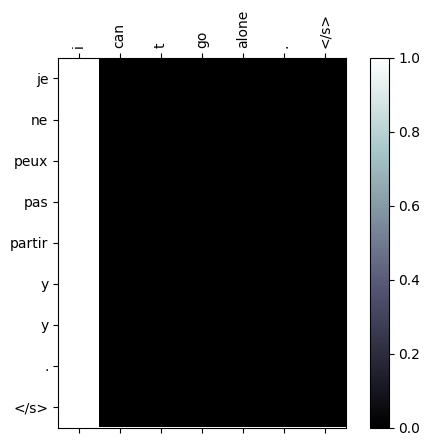

In [15]:
def show_attention(input_words, output_words, attentions):
    # 색상 바를 가진 plot 설정
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone') # attention을 나타내는 행렬을 plot으로 표현
    fig.colorbar(cax) # 색상 바 추가

    # 축 설정
    ax.set_xticklabels([''] + input_words, rotation=90) # x축에 입력 단어 설정
    ax.set_yticklabels([''] + output_words) # y축에 출력 단어 설정

    # 모든 눈금에 레이블 표시
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show() # plot 표시
    plt.close()


test = random.choice(train_data) # 학습 데이터에서 무작위로 하나 선택
input_ = test[0] # 입력 데이터
truth = test[1] # 실제 값

output, hidden = encoder(input_, [input_.size(1)]) # 인코더를 통해 출력과 히든 상태 얻음
pred, attn = decoder.decode(hidden, output) # 디코더를 통해 예측값과 attention 얻음

input_ = [index2source[i] for i in input_.data.tolist()[0]] # 입력 데이터를 단어로 변환
pred = [index2target[i] for i in pred.data.tolist()] # 예측값을 단어로 변환

# 결과 출력
print('Source : ',' '.join([i for i in input_ if i not in ['</s>']])) # 입력 문장 출력
print('Truth : ',' '.join([index2target[i] for i in truth.data.tolist()[0] if i not in [2, 3]])) # 실제 문장 출력
print('Prediction : ',' '.join([i for i in pred if i not in ['</s>']])) # 예측 문장 출력

if USE_CUDA:
    attn = attn.cpu() # CUDA를 사용하는 경우, attention을 CPU로 이동

show_attention(input_, pred, attn.data) # attention을 plotting